In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

torch.Size([4, 2])


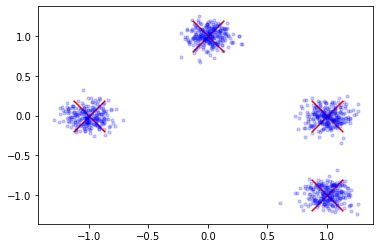

In [3]:
means_base = torch.tensor([[1., 0.], [-1., 0], [0., 1.], [1, -1]])
print(means_base.shape)

def generate_data(n_samples, means=None, stds=None, p=None):
    if means is None:
        means = means_base
    if stds is None:
        stds = torch.ones_like(means)/10.
    if p is None:
        p = torch.ones(len(means))/len(means)
        
    data = torch.randn(n_samples, len(means), 2)
    data = data*stds+means
    
    idx = torch.multinomial(p, num_samples=(n_samples), replacement=True)
    return data[torch.arange(n_samples), idx]
    
    
    
plt.scatter(*to_np(means_base).T, marker='x', color='r', s=1000)
x = generate_data(1000)
plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    


In [4]:
torch.manual_seed(0)
x = generate_data(10)

# k means clustering (teleport centroids)

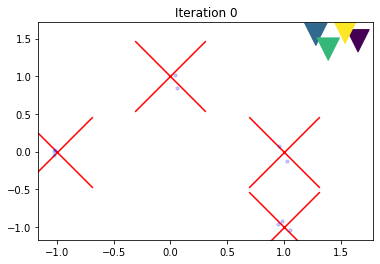

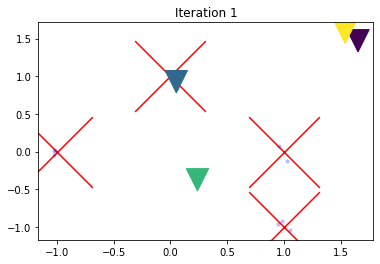

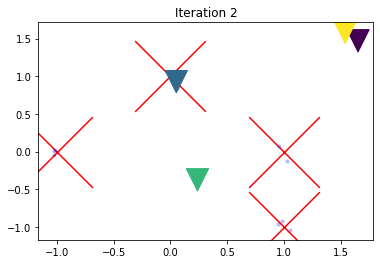

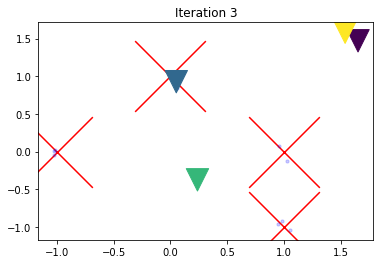

In [5]:
torch.manual_seed(0)
theta = torch.randn(4, 2)/10.+1.5

# plt.figure(figsize=(20, 5))
for i in range(4):
    # plt.subplot(1, 3, i+1)
    plt.title(f'Iteration {i}')
    plt.scatter(*to_np(means_base).T, marker='x', color='r', s=5000)
    plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*to_np(theta).T, marker='v', c=np.arange(len(theta)), s=500)
    # plt.show()
    # plt.imshow(to_np(similarity[:, torch.randperm(len(x))[:10]]))
    plt.show()
    
    similarity = -torch.linalg.norm(theta[:, None, :]-x[None, :, :], dim=-1)
    idx = similarity.argmax(dim=0)
    
    # plt.scatter(*to_np(x[idx==1]).T, c='r', s=10)
    # plt.scatter(*to_np(x[idx==2]).T, c='g', s=10)
    # plt.show()
    
    target = torch.stack([x[idx==i].mean(dim=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = target
# plt.show()


# k means but with SGD

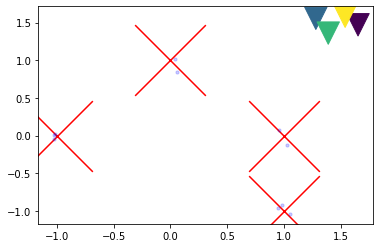

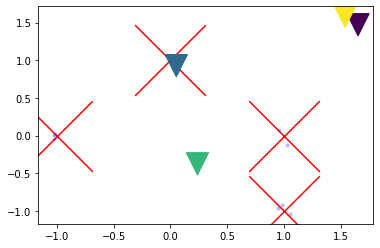

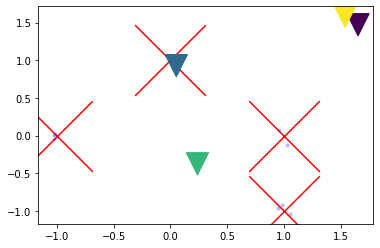

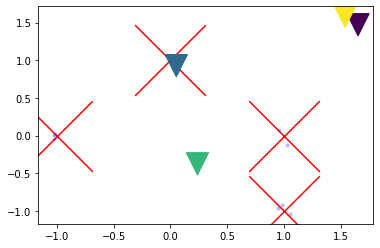

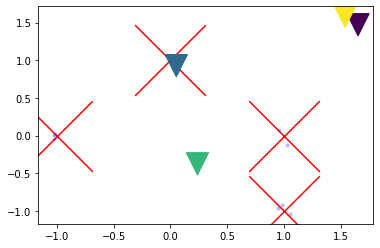

In [6]:
torch.manual_seed(0)

alpha = .0 # alpha=0 means the centroid teleports and becomes k means clustering
theta = torch.randn(4, 2)/10. + 1.5

for i in range(5):
    plt.scatter(*to_np(means_base).T, marker='x', color='r', s=5000)
    plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*to_np(theta).T, marker='v', c=np.arange(len(theta)), s=500)
    plt.show()
    
    similarity = -np.linalg.norm(theta[:, None, :]-x, axis=-1)
    idx = similarity.argmax(axis=0)
    
    target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = alpha*theta + (1-alpha)*target


this doesn't get the double softmax idea exactly right but:

"soft k means clustering softmax"

https://www.cs.cmu.edu/~02251/recitations/recitation_soft_clustering.pdf

https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec14_handout.pdf

In the second softmax step,
rather than taking another softmax (over data), they just take a weight sum (over data).
This is legal because the first softmax ensures everything is in (0,1) range.


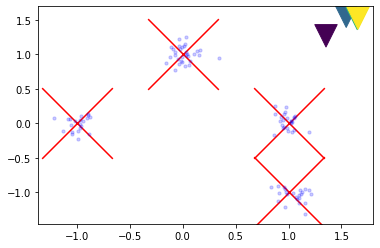

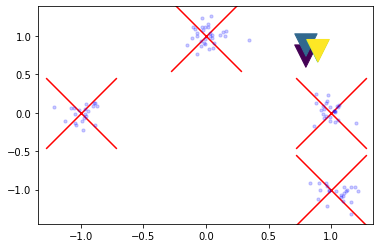

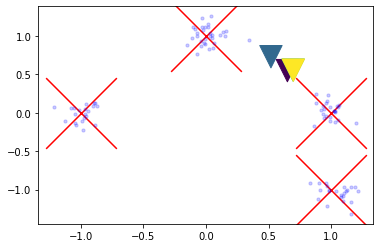

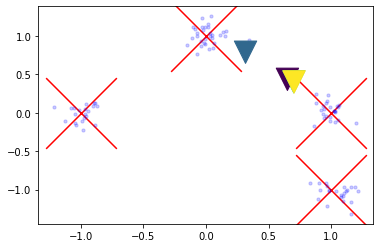

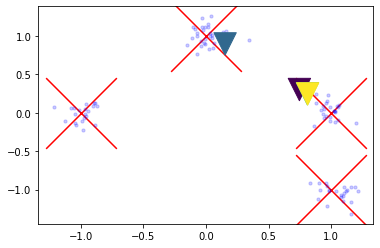

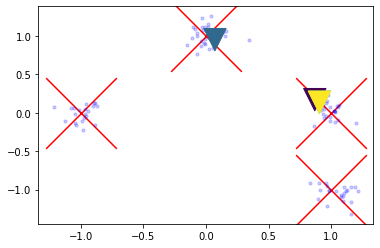

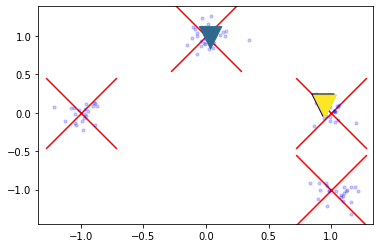

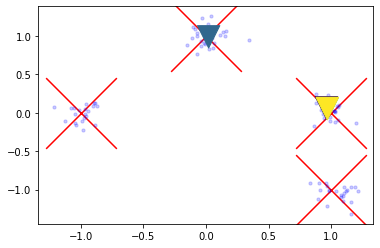

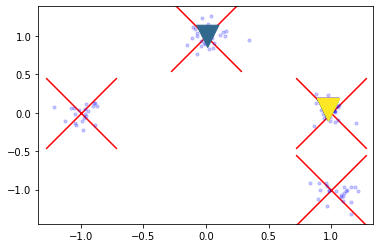

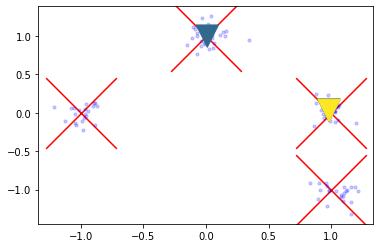

In [7]:
torch.manual_seed(0)
x = generate_data(100)

alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
theta = torch.randn(4, 2)/10. + 1.5

for i in range(10):
    plt.scatter(*to_np(means_base).T, marker='x', color='r', s=5000)
    plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*to_np(theta).T, marker='v', c=np.arange(len(theta)), s=500)
    plt.show()
    
    beta = 5.
    similarity = -torch.linalg.norm(theta[:, None, :]-x, dim=-1)
    # idx = dists.argmin(axis=0)
    dt = (beta*similarity).softmax(dim=0)
    dx = (beta*similarity).softmax(dim=1)
    # print(dx)
    # plt.plot(dx[0])
    # plt.show()
    
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = theta
    
    dtx = (5.*similarity).softmax(dim=1)
    target = dtx@x
    
    theta = alpha*theta + (1-alpha)*target

now to do with softmax attention movement and using dot product as distance with lots of clusters
and dynamically generating data for each step rather than using fixed dataset

In [168]:
torch.manual_seed(0)
hm = HopfieldMemory((5, 2), alpha=1.)
for i in range(5):
    nK = torch.randn(5, 2)
    nV = torch.randn(5, 2)
    hm.set_target(nK, nV)
    hm.step()

In [169]:
hm.Km

Parameter containing:
tensor([[ 1.3441,  2.3832],
        [-0.5665, -1.1536],
        [-2.5023,  0.8756],
        [-2.6726, -0.0313],
        [ 0.4988, -0.5233]], requires_grad=True)

In [170]:
nK

tensor([[ 1.3441,  2.3832],
        [-0.5665, -1.1536],
        [-2.5023,  0.8756],
        [-2.6726, -0.0313],
        [ 0.4988, -0.5233]])

In [171]:
aa = torch.tensor([1.])
aa.grad = torch.tensor([-.1])
print(aa.item())

a = aa.clone()
a.grad = aa.grad.clone()
opt = torch.optim.SGD([a], lr=1.)
opt.step()
print(a.item())
      
a = aa.clone()
a.grad = aa.grad.clone()
opt = torch.optim.Adam([a], lr=.1)
opt.step()
print(a.item())

1.0
1.100000023841858
1.100000023841858


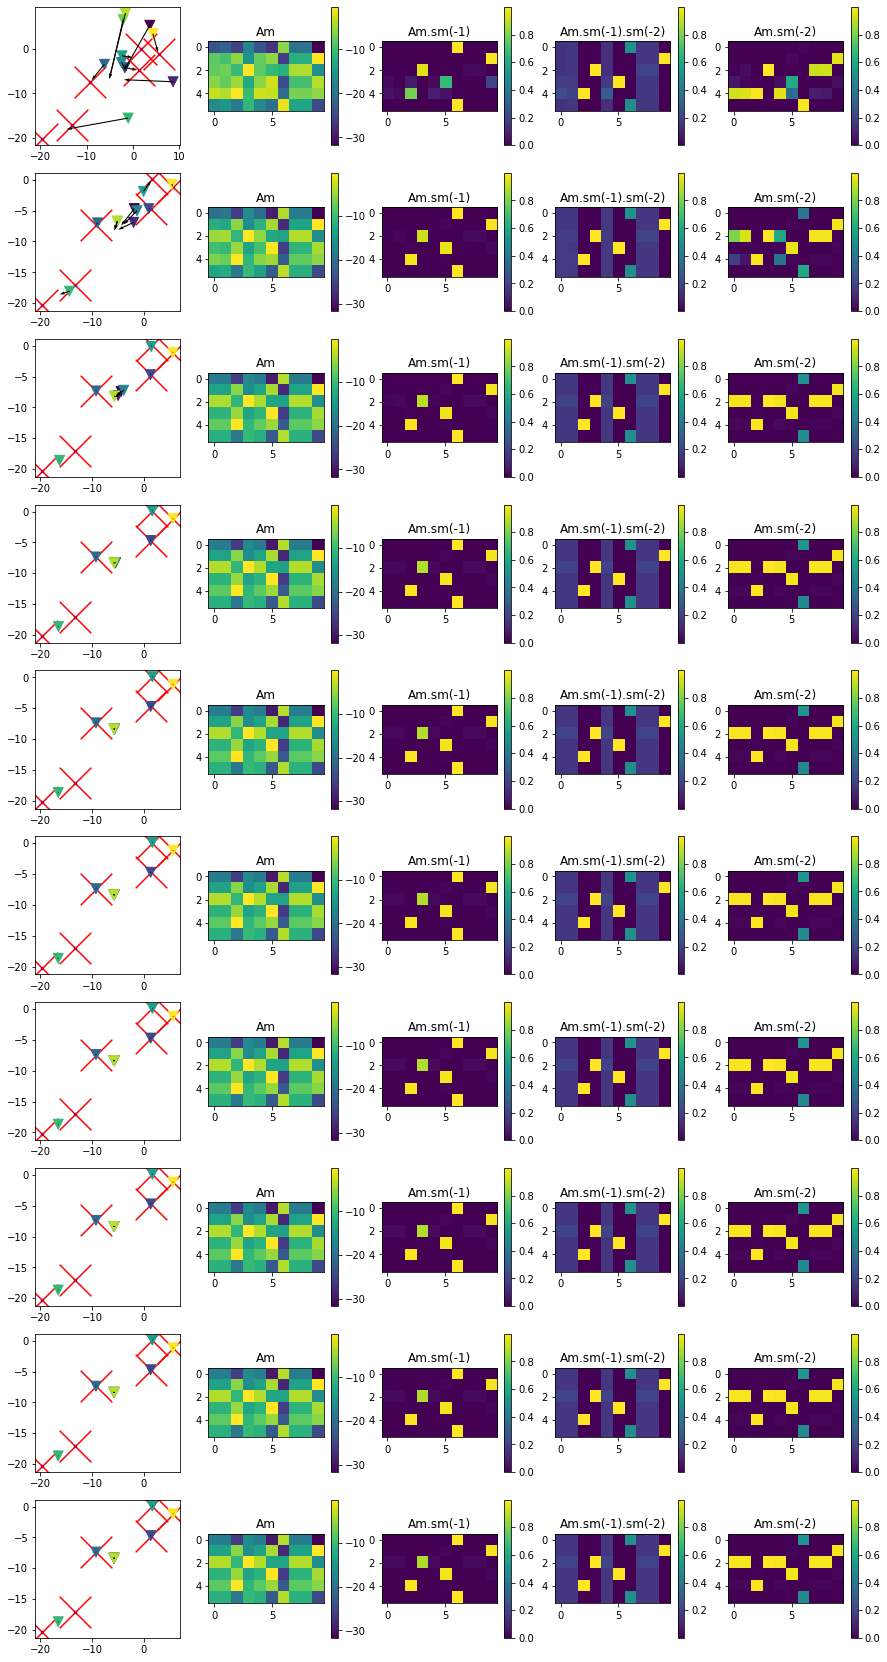

In [54]:
torch.manual_seed(3)

n_keys = 10
n_queries = 6

# alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
hm = HopfieldMemory((n_keys, 2), alpha=0.9, opt='sgd', lr=1.)
hm.reset(5.)
# hm = HopfieldMemory(4, 2, alpha=.7, opt='adam', lr=.5)

means = torch.randn(n_queries, 2)*10.
# x = generate_data(20, means)
x = means
beta1 = 1
beta2 = 10.

n_iters = 10
plt.figure(figsize=(3*5, 3*n_iters))
for i in range(n_iters):
    plt.subplot(n_iters, 5, i*5+1)
    hm.set_target_with_data(x.to(hm.Km), None, dist_metric='euclidean', beta1=beta1, beta2=beta2)
    
    plt.scatter(*to_np(means).T, marker='x', color='r', s=1000)
    plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    # plt.scatter(*to_np(hm.K).T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.scatter(*to_np(hm.Km).T, marker='v', c=np.arange(len(hm.Km)), s=100)
    plt.quiver(*to_np(hm.Km).T, *to_np(hm.Km.grad).T, angles='xy', scale_units='xy', scale=1)
    
    hm.step()
    
    KT = hm.Km.transpose(-1, -2)
    Am = -torch.linalg.norm(x[..., None, :] - hm.Km, dim=-1)
    plt.subplot(n_iters, 5, i*5+2)
    plt.title('Am'); plt.imshow(Am); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+3)
    plt.title('Am.sm(-1)'); plt.imshow((beta1*Am).softmax(dim=-1)); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+4)
    plt.title('Am.sm(-1).sm(-2)'); plt.imshow((beta2*(beta1*Am).softmax(dim=-1)).softmax(dim=-2)); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+5)
    plt.title('Am.sm(-2)'); plt.imshow((beta1*Am).softmax(dim=-2)); plt.colorbar()
    
plt.show()
    

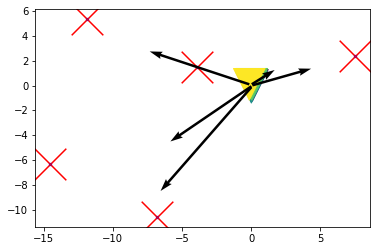

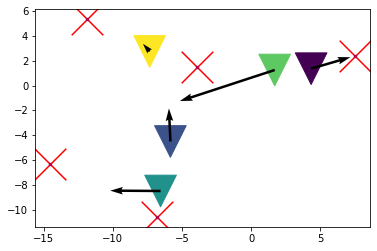

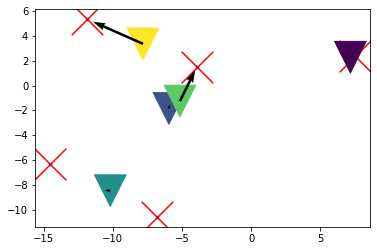

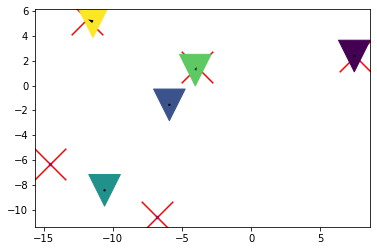

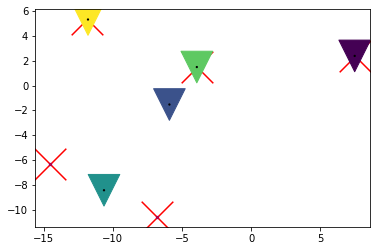

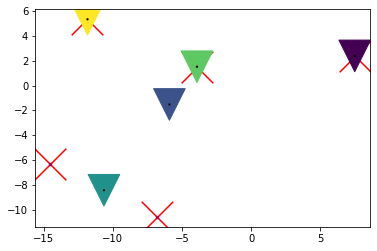

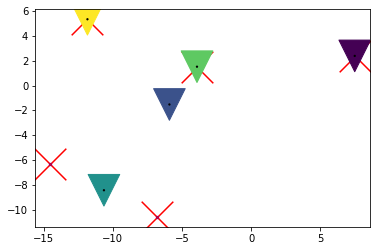

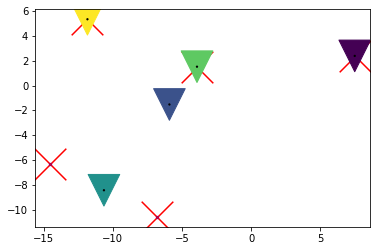

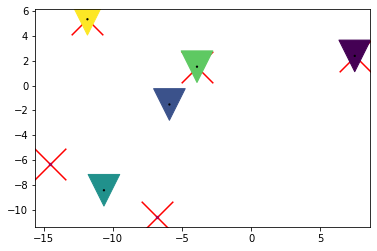

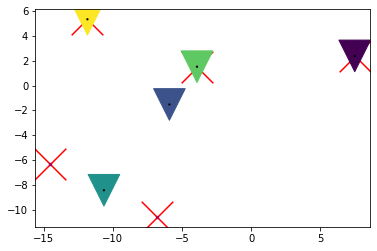

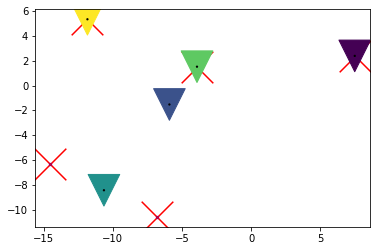

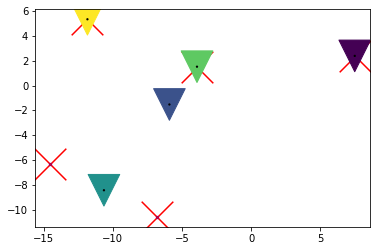

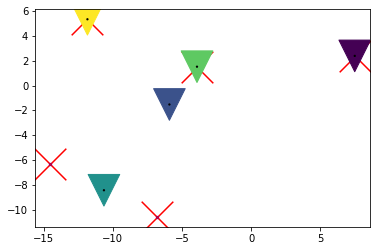

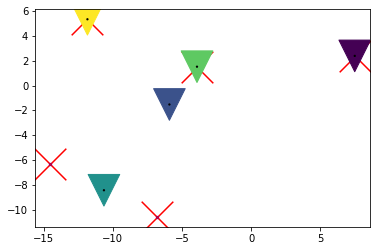

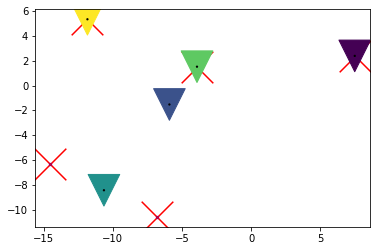

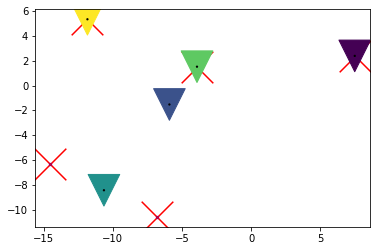

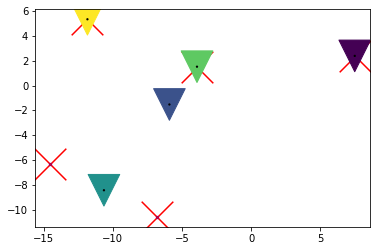

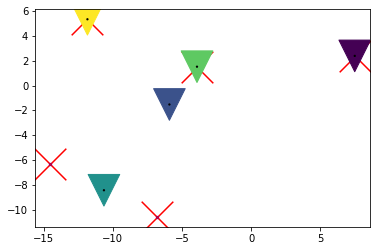

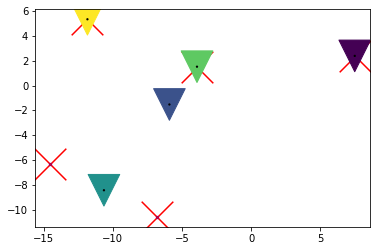

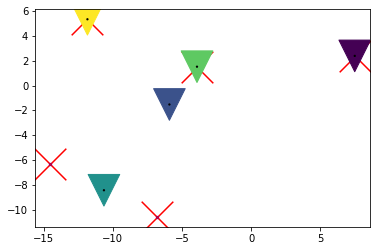

In [11]:
torch.manual_seed(3)

# alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
hm = HopfieldMemory((5, 2), alpha=0.9, opt='sgd', lr=1.)
# hm = HopfieldMemory(4, 2, alpha=.7, opt='adam', lr=.5)

means = torch.randn(5, 2)*10.
# x = generate_data(20, means)
x = means

for i in range(20):
    hm.set_target_with_data(x.to(hm.Km), None, dist_metric='euclidean', beta1=10., beta2=10.)
    
    plt.scatter(*to_np(means).T, marker='x', color='r', s=1000)
    plt.scatter(*to_np(x).T, marker='o', color=(0, 0, 1., 0.2), s=10)
    # plt.scatter(*to_np(hm.K).T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.scatter(*to_np(hm.Km).T, marker='v', c=np.arange(len(hm.Km)), s=1000)
    plt.quiver(*to_np(hm.Km).T, *to_np(hm.Km.grad).T, angles='xy', scale_units='xy', scale=1)
    plt.show()
    
    hm.step()
    

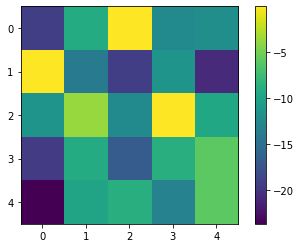

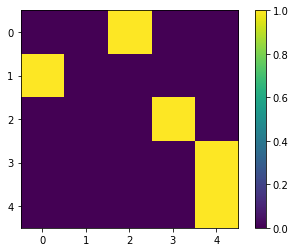

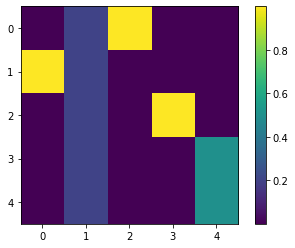

In [226]:
Am = hm.Am
plt.imshow(to_np(Am)); plt.colorbar()
plt.show()
Am = (10*Am).softmax(dim=-1)
plt.imshow(to_np(Am)); plt.colorbar()
plt.show()
Am = (10*Am).softmax(dim=-2)
plt.imshow(to_np(Am)); plt.colorbar()
plt.show()

In [133]:
def softmax(a, dim=None, beta=1.):
    return (beta*a).softmax(dim=dim)

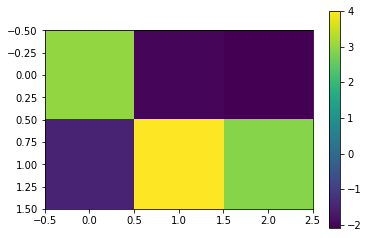

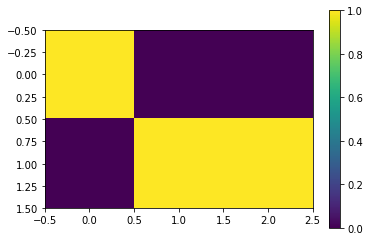

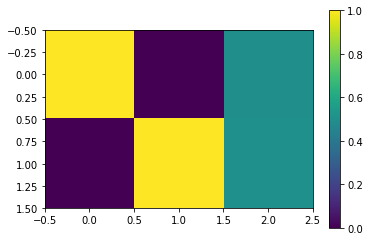

In [231]:
a = torch.tensor([[3.0, -2., -2.1], 
                  [-1.5, 4., 2.9]])

plt.imshow(to_np(a)); plt.colorbar()
plt.show()
plt.imshow(to_np(softmax(a, -2, 10.))); plt.colorbar()
plt.show()
plt.imshow(to_np(softmax(softmax(a, -1, 10.), -2, 10.)), vmin=0, vmax=1); plt.colorbar()
plt.show()

# plt.imshow(to_np(softmax(softmax(a, -2, 10.), -1, 10.)), vmin=0, vmax=1); plt.colorbar()
# plt.show()


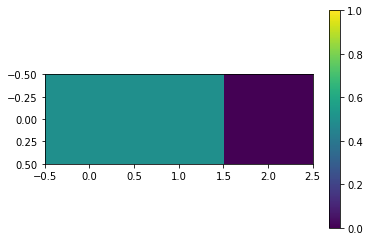

In [239]:
plt.imshow(to_np((softmax(a, -1, 10.).mean(dim=-2, keepdim=True)*10).softmax(dim=-1)), vmin=0, vmax=1); plt.colorbar()
plt.show()